# Single Object Classification

The notebook illustrates how the SquiDS package can help to create and test a single object classification model.

**Please note that the goal of this notebook is not to create the perfect ML model, but to demonstrate how to use the functionality of the SquiDS package.**

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [1]:
import sys
sys.path.insert(0, '..')

from PIL import ImageDraw, ImageFont
import tensorflow as tf
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

from helper import plot_images

In [2]:
create_dataset(
    dataset_size=10000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365,
    image_capacity=1,
    verbose=True)
create_tfrecords(verbose=True)

100%|██████████| 999/999 [00:00<00:00, 1362.40it/s]


Explore few samples from the generated dataset.

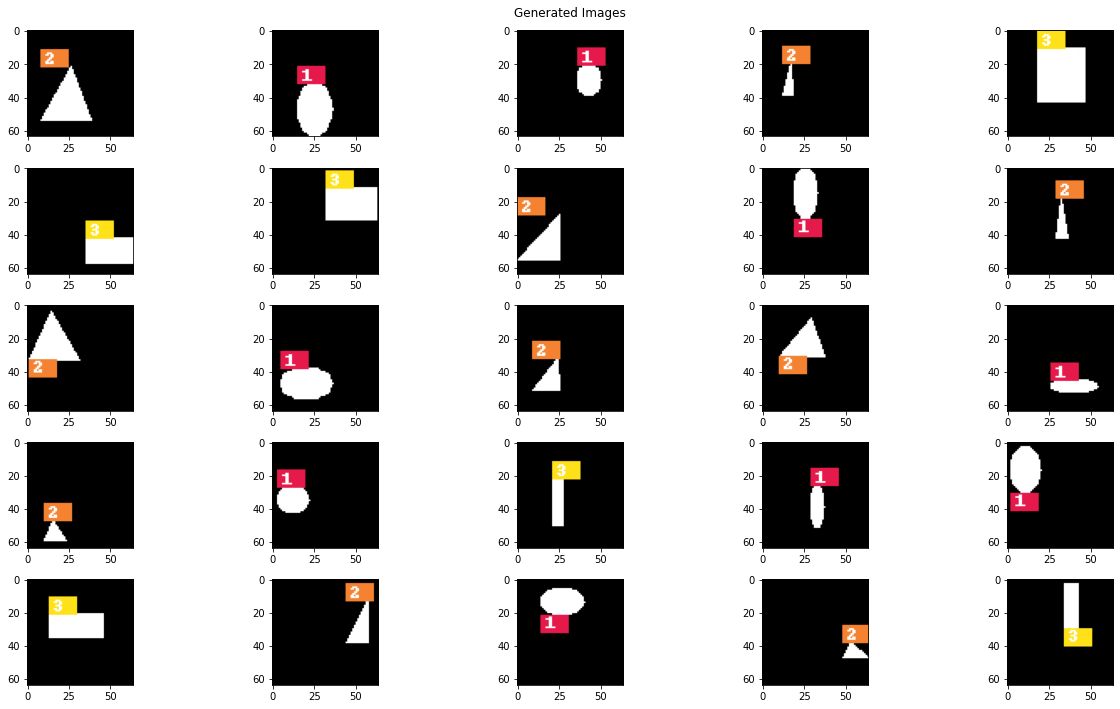

In [3]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories=True,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Generated Images")

## Train Object Classification Model

Let's create generators for train and validation datasets and compute steps per epoch for each of them. 

Note:
1. For this model we need to output categories one-hot encodings. We can do it by using the `C` output schema.
2. The number of detecting objects is 1.

In [6]:
ds_train, train_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_train", 
    output_schema = "C",
    num_detecting_objects=1,
)
print(
    "Training steps per epoch (for the default batch size 32):",
    train_steps_per_epoch
)

ds_val, val_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_val", 
    output_schema = "C",
    num_detecting_objects=1,
)
print(
    "Validation steps per epoch (for the default batch size 32):",
    val_steps_per_epoch
)

Training steps per epoch (for the default batch size 32): 219
Validation steps per epoch (for the default batch size 32): 63


Let's define a simple convolution model.

In [8]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(
			filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu'),
	tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
	metrics=tf.keras.metrics.CategoricalAccuracy()
)

Now we are ready to perform the model training. Note that the best model weights are stored in the `best_weights.h5` file.Train the model.

In [9]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_weights.h5",
    monitor='val_loss',
    mode="min",
    save_best_only=True,
    verbose=1)
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=10,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    callbacks=checkpoint_callback,
    verbose=1
)

Epoch 1/10
218/219 [============================>.] - ETA: 0s - loss: 0.7248 - categorical_accuracy: 0.6995
Epoch 1: val_loss improved from inf to 0.36589, saving model to best_weights.h5
219/219 [==============================] - 8s 33ms/step - loss: 0.7227 - categorical_accuracy: 0.7005 - val_loss: 0.3659 - val_categorical_accuracy: 0.8328
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.1247 - categorical_accuracy: 0.9606
Epoch 2: val_loss improved from 0.36589 to 0.15079, saving model to best_weights.h5
219/219 [==============================] - 11s 51ms/step - loss: 0.1247 - categorical_accuracy: 0.9606 - val_loss: 0.1508 - val_categorical_accuracy: 0.9390
Epoch 3/10
217/219 [============================>.] - ETA: 0s - loss: 0.0238 - categorical_accuracy: 0.9955
Epoch 3: val_loss improved from 0.15079 to 0.11817, saving model to best_weights.h5
219/219 [==============================] - 7s 32ms/step - loss: 0.0238 - categorical_accuracy: 0.9954 - val_loss: 0

## Test Object Classification Model

Let's test the model on the unseen data.

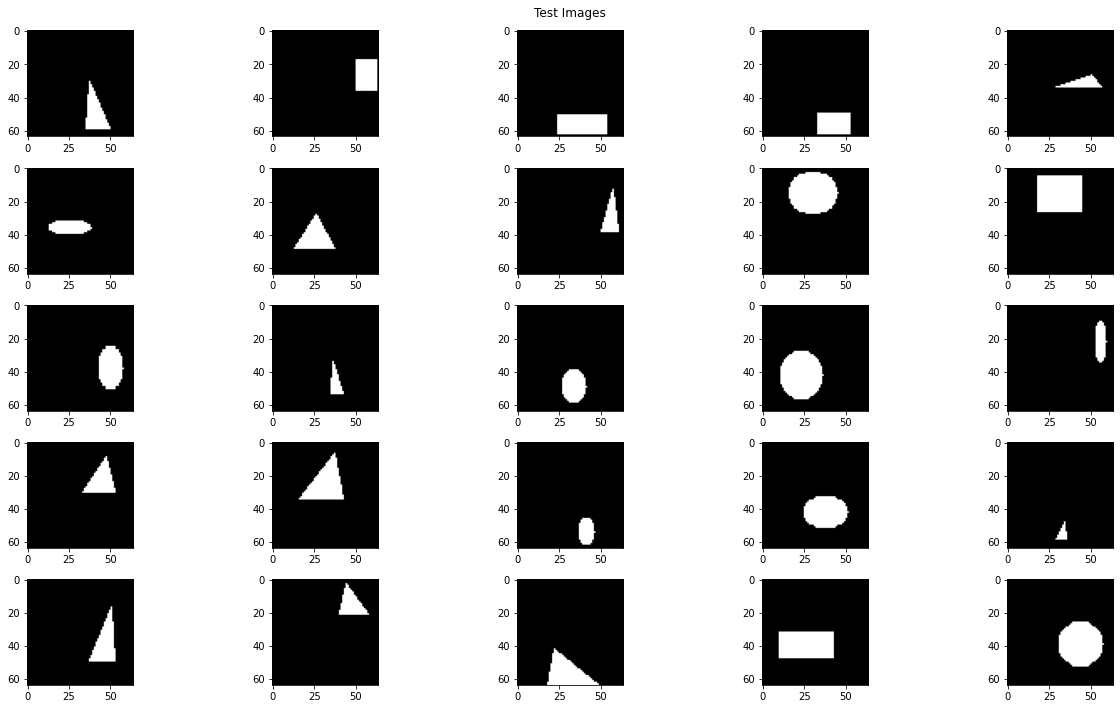

In [14]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Test Images")

Make model prediction and overlay results on the test images.

Categories ID:
- 0 - Ellipse;
- 1 - Triangle;
- 2 - Rectangle;


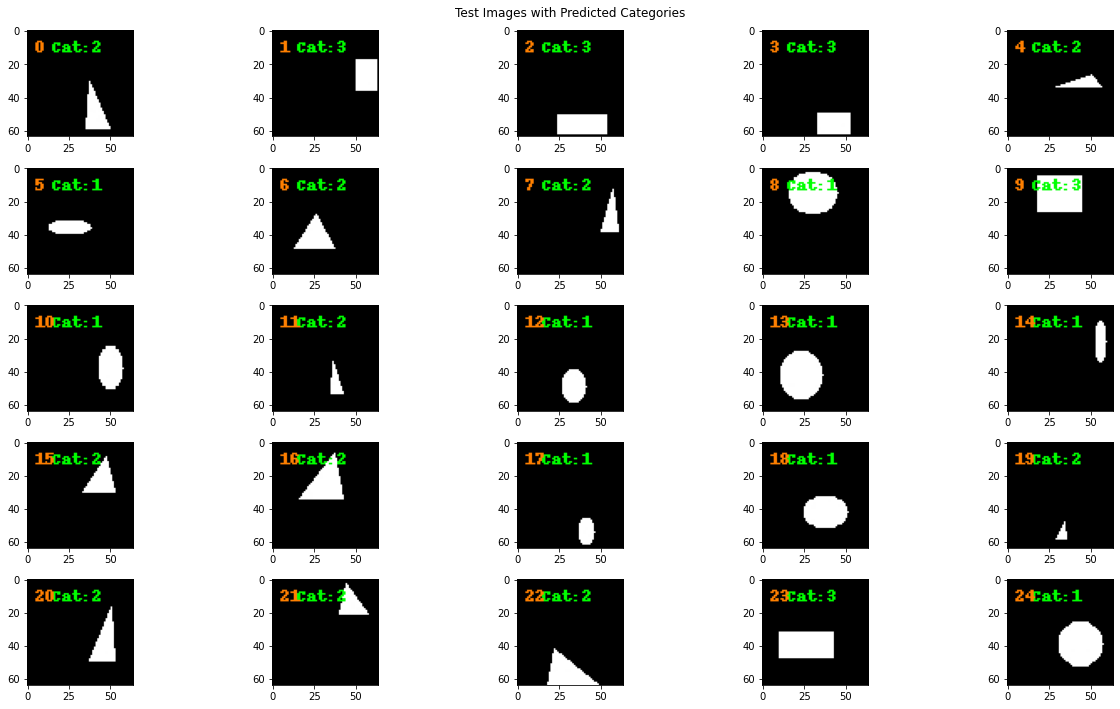

In [15]:
preprocessed_images = np.array(
    [np.array(image) for image in images]
) / 255.0

model.load_weights("best_weights.h5")
predictions = model.predict(preprocessed_images)

sample = 0
for image, prediction in zip(images, predictions):
    draw = ImageDraw.Draw(image)

    category_id = np.argmax(prediction)

    draw.text(
        (15, 5),
        "Cat:" + str(category_id),
        "#00FF00",
        font=ImageFont.load_default(),
    )

    draw.text(
        (5,5),
        str(sample),
        "#FF8000",
        font=ImageFont.load_default(),
    )
    sample += 1

plot_images(images, "Test Images with Predicted Categories")